In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models._utils import IntermediateLayerGetter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import sys
sys.path.append('../src/python')
from dataset_with_path import MyImageFolder #this has to be in a python file, if in jupyter nb it crashes

plt.ion()   # interactive mode

## Prepping Data for Training

In [3]:
data_dir = '../data'
annotation_file = 'images.csv'
image_dir = 'images_original'

annotation_file = os.path.join(data_dir, annotation_file)
image_dir = os.path.join(data_dir, image_dir)

In [4]:
annotations = pd.read_csv(annotation_file)
annotations.label = annotations.label.apply(
    lambda x: x.lower().replace('-', '_').replace(' ', '_')
)
annotations = annotations[annotations.label!='skip'].reset_index(drop=True)
annotations.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,not_sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,t_shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,not_sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,t_shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,shoes,False


### seperate images by class and create train/val splits

In [5]:
# for label in annotations.label.unique():
#     label_dir = os.path.join(data_dir, 'train/'+label)
    
    
# for img in tmp.image:
#         old = os.path.join(image_dir, img+'.jpg')
#         new = os.path.join(label_dir, img+'.jpg')

In [6]:
# # need to seperate images by class
# for label in annotations.label.unique():
#     label_dir = os.path.join(data_dir, 'train/'+label)
#     if not os.path.isdir(label_dir):
#         os.mkdir(label_dir)
#     tmp = annotations[annotations.label==label]
#     for img in tmp.image:
#         old = os.path.join(image_dir, img+'.jpg')
#         new = os.path.join(label_dir, img+'.jpg')
#         os.rename(old, new)

#         # need to seperate out for some validation data too
# # split data ~ 90:10 train:val
# # written to move val back into train and regenerate val if re-run
# for label in annotations.label.unique():
#     label_dir_old = os.path.join(data_dir, 'train/'+label)
#     label_dir = os.path.join(data_dir, 'val/'+label)
#     if not os.path.isdir(label_dir):
#         os.mkdir(label_dir)
#     tmp = annotations[annotations.label==label]
#     for img in tmp.image:
#         old = os.path.join(label_dir_old, img+'.jpg')
#         new = os.path.join(label_dir, img+'.jpg')
#         if os.path.isfile(new):
#             os.rename(new, old)
#         if random.random() <= 0.1:
#             os.rename(old, new)

## Data Loaders

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

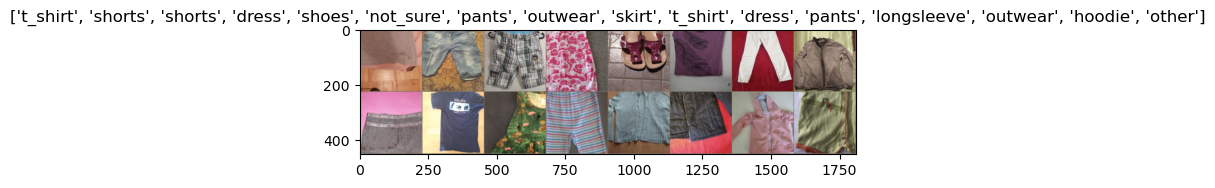

In [7]:
# check loader

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training

In [10]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [14]:
model_path = 'best_model.pt'

# simple save/load
#torch.save(model_ft, model_path)
model_ft = torch.load(model_path)

# set to eval
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model prediction check

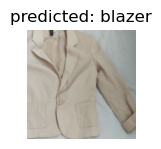

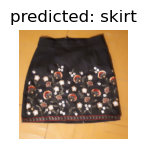

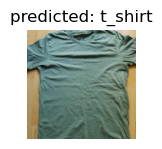

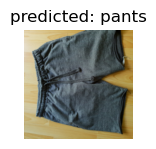

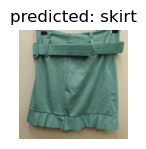

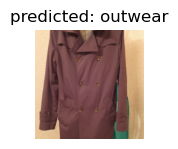

In [15]:
visualize_model(model_ft)

## Embedding Calculation

In [74]:
new_m = IntermediateLayerGetter(model_ft, {'avgpool': 'features'})

In [77]:
# new dataloader that included path
datasets_ = {x: MyImageFolder(os.path.join(data_dir, x),
                                          data_transforms['val'])
                  for x in ['train', 'val']}
dataloaders_ = {x: torch.utils.data.DataLoader(datasets_[x], batch_size=64,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}

In [78]:
outputs = []
classes = []
paths = []
with torch.no_grad():
    for inputs, labels, path in tqdm.tqdm(dataloaders_['train']):
        outputs.append(torch.squeeze(new_m(inputs)['features']))
        classes.append(labels)
        paths.append(path)
    for inputs, labels, path in tqdm.tqdm(dataloaders_['val']):
        outputs.append(torch.squeeze(new_m(inputs)['features']))
        classes.append(labels)  
        paths.append(path)

100%|█████████████████████████████████████████████| 9/9 [00:48<00:00,  5.40s/it]


In [79]:
outputs = torch.vstack(outputs)
classes = torch.concat(classes)
paths = [p for path in paths for p in path]
img_ids = [p.split('/')[-1][:-4] for p in paths]

## Similarity

In [75]:
def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [80]:
matrix = sim_matrix(outputs, outputs)
class_names_map = {k: v for k, v in enumerate(class_names)}
items = [class_names_map[c.item()]+'_'+str(i) for i, c in enumerate(classes)]
sim_df = pd.DataFrame(matrix.numpy(), columns = items, index=items)
sim_df['paths'] = paths

In [82]:
def visualize_model(df, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for row in df[1:].iterrows():
        row = row[1]
        img = mpimg.imread(row.paths)
        
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'similarity: {row[df.columns[0]]:.2}')
        plt.imshow(img);

        if images_so_far == num_images:
            return
        
def top_n(sim_df, item, n=10, plot_n=None, visualize = True, best=True):
    if best:
        df = sim_df[[item, 'paths']].sort_values(item, ascending=False)[1:].head(n) # top n
    else: 
        df = sim_df[[item, 'paths']].sort_values(item, ascending=True).head(n) # bottom n
        
    if visualize:
        p = sim_df.loc[item].paths
        img = mpimg.imread(p)
        plt.imshow(img);
        plt.title(df.columns[0])
        if plot_n is None:
            plot_n = n
        visualize_model(df, num_images=plot_n)

        return df

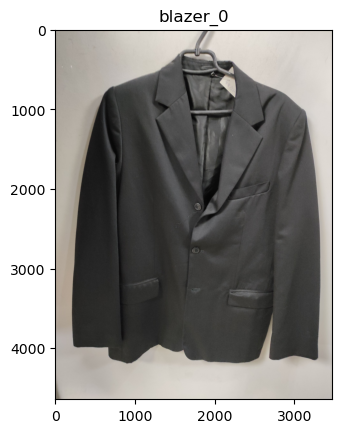

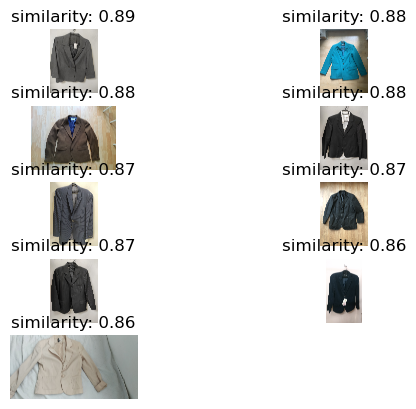

In [83]:
item = sim_df.index[0]
df = top_n(sim_df, item)

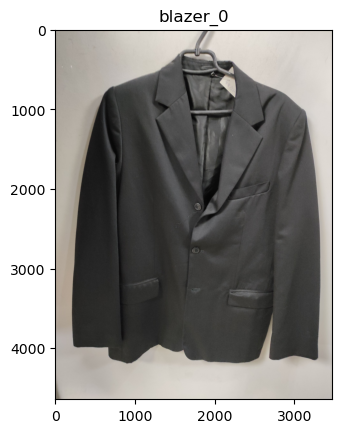

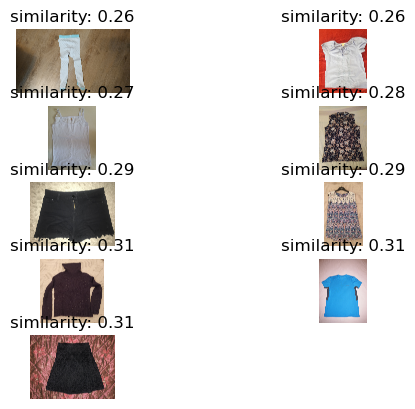

In [84]:
df = top_n(sim_df, item, best=False)

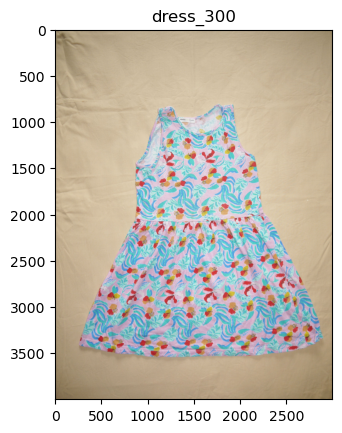

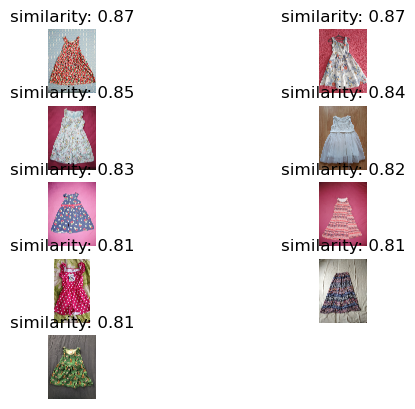

In [85]:
item = sim_df.index[300]
df = top_n(sim_df, item)

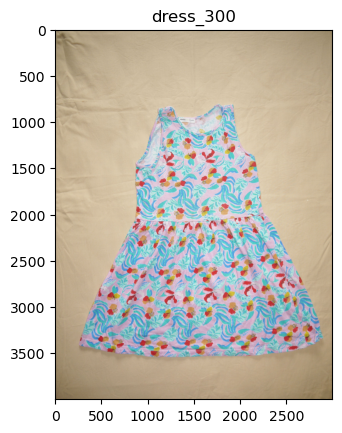

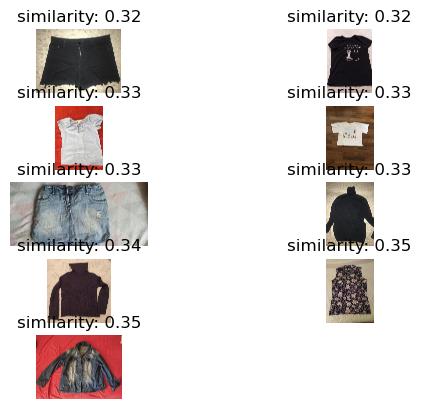

In [86]:
df = top_n(sim_df, item, best = False)

In [96]:
sim_df

,blazer_0,blazer_1,blazer_2,blazer_3,blazer_4,blazer_5,blazer_6,blazer_7,blazer_8,blazer_9,...,top_5382,undershirt_5383,undershirt_5384,undershirt_5385,undershirt_5386,undershirt_5387,undershirt_5388,undershirt_5389,undershirt_5390,paths
blazer_0,1.000000,0.845582,0.833416,0.695798,0.748811,0.656999,0.781280,0.800928,0.851923,0.834541,...,0.519456,0.412395,0.464353,0.436189,0.430207,0.435946,0.403662,0.411196,0.418829,../data/train/blazer/00b8048d-635e-4e56-b182-0...
blazer_1,0.845582,1.000000,0.785329,0.658591,0.688491,0.592226,0.731951,0.689509,0.768211,0.899040,...,0.504516,0.416559,0.503111,0.433977,0.400076,0.476409,0.439077,0.444998,0.433939,../data/train/blazer/01a54355-b591-45e9-a248-1...
blazer_2,0.833416,0.785329,1.000000,0.620808,0.672076,0.582476,0.727623,0.753329,0.798815,0.814387,...,0.496529,0.368897,0.476272,0.393492,0.418253,0.471049,0.376462,0.370387,0.417672,../data/train/blazer/03c6360d-734d-435b-92a8-6...
blazer_3,0.695798,0.658591,0.620808,1.000000,0.833742,0.641657,0.694551,0.670159,0.787860,0.694283,...,0.561814,0.529569,0.579610,0.573817,0.490857,0.488520,0.505786,0.526611,0.535170,../data/train/blazer/06aaacf1-bade-43fc-89de-5...
blazer_4,0.748811,0.688491,0.672076,0.833742,1.000000,0.601464,0.701183,0.748725,0.818754,0.719728,...,0.533150,0.432456,0.490125,0.465081,0.438171,0.432270,0.437650,0.425696,0.456263,../data/train/blazer/0d9f1bf9-0008-4247-b22b-8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
undershirt_5386,0.430207,0.400076,0.418253,0.490857,0.438171,0.480125,0.474442,0.527420,0.426483,0.352666,...,0.746942,0.772734,0.682438,0.751836,1.000000,0.700585,0.674309,0.676782,0.764130,../data/val/undershirt/2cf630a8-cb6b-48df-9d16...
undershirt_5387,0.435946,0.476409,0.471049,0.488520,0.432270,0.492669,0.453088,0.502690,0.485237,0.418352,...,0.669561,0.693110,0.756365,0.753881,0.700585,1.000000,0.708681,0.746175,0.709127,../data/val/undershirt/41e6b2af-2790-4b8c-a764...
undershirt_5388,0.403663,0.439077,0.376462,0.505786,0.437650,0.444219,0.429121,0.463592,0.413174,0.397968,...,0.664281,0.728772,0.753109,0.713508,0.674309,0.708681,1.000000,0.742963,0.748563,../data/val/undershirt/6cd3167b-27a1-4dc8-b929...
undershirt_5389,0.411196,0.444998,0.370387,0.526611,0.425696,0.448780,0.450016,0.461809,0.436359,0.405272,...,0.645142,0.747533,0.742011,0.808311,0.676782,0.746174,0.742963,1.000000,0.710416,../data/val/undershirt/b5856585-87b2-4c0e-904d...


In [112]:
def index_lookup(path):
    return sim_df.paths[sim_df.paths==path].index[0]
index_lookup('../data/train/blazer/00b8048d-635e-4e56-b182-071fb24eea32.jpg')

'blazer_0'

## embeddings

In [88]:
feat_name=['feature_'+str(i) for i in range(len(outputs[0]))]
feat=[np.array(outputs)[:,i] for i in range(len(outputs[0]))]

final_df=annotations[['image','label']].copy()
feats=pd.DataFrame({k:v for k,v in zip(feat_name, feat)})

embeddings=pd.concat([final_df, feats], axis=1)
embeddings.to_csv('embeddings.csv', index=False)
embeddings

,image,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,4285fab0-751a-4b74-8e9b-43af05deee22,not_sure,0.812021,3.561842,1.156692,1.883612,2.835385,0.191766,1.091118,0.146255,...,0.365326,1.465184,2.032974,0.778278,1.159273,0.507430,0.008390,1.090411,0.530454,0.465696
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,t_shirt,0.839928,3.436844,2.056577,1.622143,4.094784,0.151096,0.673825,0.226439,...,1.046314,2.611942,4.221269,1.394498,1.778227,0.406762,0.273420,2.458988,0.473171,0.113551
2,00627a3f-0477-401c-95eb-92642cbe078d,not_sure,2.326742,4.287974,0.413634,1.245557,3.946273,0.440881,1.117319,0.001980,...,0.035449,1.420525,2.695267,2.044414,1.137071,0.995672,0.033304,1.482500,0.727720,0.365002
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,t_shirt,0.699387,1.161603,0.722891,1.509604,2.983932,0.100378,4.815662,0.062508,...,0.902799,0.006310,0.065833,1.427231,1.767513,1.128178,0.458749,1.869740,0.060592,2.291681
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,shoes,1.268103,1.715540,0.520359,0.734834,2.988948,0.084660,3.451318,0.296938,...,0.297683,0.603193,0.588171,1.047452,0.519240,1.610032,0.268719,1.916745,0.354742,1.263562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,dfd4079d-967b-4b3e-8574-fbac11b58103,shorts,0.766182,0.031907,1.569184,2.543739,0.300702,0.050608,0.005247,4.186441,...,1.067379,0.006378,0.140420,3.572777,1.606291,0.986320,2.921135,0.559903,0.785799,0.883515
5387,befa14be-8140-4faf-8061-1039947e329d,body,1.350408,0.246742,0.697709,1.459406,0.239419,0.814408,0.369147,3.156189,...,0.337185,0.295552,0.042497,0.653818,3.442614,0.177568,2.556228,2.410223,0.898271,1.111286
5388,5379356a-40ee-4890-b416-2336a7d84061,shorts,1.144403,0.543491,0.263641,0.596204,0.362284,0.795961,0.201685,1.298998,...,1.024761,0.618558,1.038637,1.774426,5.185067,0.175654,2.714302,0.661284,0.604724,0.928808
5389,65507fb8-3456-4c15-b53e-d1b03bf71a59,shoes,0.777243,0.090099,1.899299,0.359302,0.638384,0.573364,0.043110,2.471715,...,1.014922,0.151747,0.277921,1.201281,4.387005,0.140437,3.166071,1.633245,0.619455,3.964281
